<a href="https://colab.research.google.com/github/ebinjomonkottakal/Tensorflow_advanced/blob/main/Class_Activation_Maps_with_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,MaxPooling2D,GlobalAveragePooling2D
import scipy as sp

# Download and Prepare the Data

In [3]:
# load fashion mnist dataset
(X_train,Y_train),(X_test,Y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
# Put an additional axis for the channels of the image.
# Fashion MNIST is grayscale so we place 1 at the end. Other datasets
# will need 3 if it's in RGB.
X_train = X_train.reshape(60000, 28, 28,1)
X_test = X_test.reshape(10000, 28, 28,1)

X_train = X_train/255
X_test = X_test/255

X_train = X_train.astype('float')
X_test = X_test.astype('float')

In [9]:
def show_img(img):
  img = np.array(img,dtype='float')
  img = img.reshape((28,28))
  plt.imshow(img)

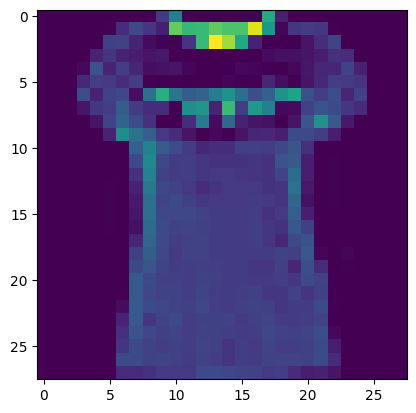

In [13]:
show_img(X_train[34])

In [14]:
# use the Sequential API
model = Sequential()

# notice the padding parameter to recover the lost border pixels when doing the convolution
model.add(Conv2D(16,input_shape=(28,28,1),kernel_size=(3,3),activation='relu',padding='same'))
# pooling layer with a stride of 2 will reduce the image dimensions by half
model.add(MaxPooling2D(pool_size=(2,2)))

# pass through more convolutions with increasing filters
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))

# use global average pooling to take into account lesser intensity pixels
model.add(GlobalAveragePooling2D())

# output class probabilities
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [15]:
# configure the training
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# train the model. just run a few epochs for this test run. you can adjust later.
model.fit(X_train,Y_train,batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 74s 43ms/step - loss: 0.6066 - accuracy: 0.7742 - val_loss: 0.3987 - val_accuracy: 0.8493
Epoch 2/5
1688/1688 [==============================] - 82s 48ms/step - loss: 0.3676 - accuracy: 0.8658 - val_loss: 0.3242 - val_accuracy: 0.8825
Epoch 3/5
1688/1688 [==============================] - 69s 41ms/step - loss: 0.3115 - accuracy: 0.8854 - val_loss: 0.2961 - val_accuracy: 0.8908
Epoch 4/5
1688/1688 [==============================] - 76s 45ms/step - loss: 0.2752 - accuracy: 0.8984 - val_loss: 0.2804 - val_accuracy: 0.8975
Epoch 5/5
1688/1688 [==============================] - 71s 42ms/step - loss: 0.2485 - accuracy: 0.9079 - val_loss: 0.2573 - val_accuracy: 0.9063


In [17]:
#final convolutional layer
print(model.layers[-3].name)

#global average pooling layer
print(model.layers[-2].name)

#output of the classifier
print(model.layers[-1].name)

conv2d_3
global_average_pooling2d
dense


In [19]:
# same as previous model but with an additional output
cam_model = Model(inputs = model.input,outputs = (model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          1849

In [20]:
# get the features and results of the test images using the newly created model
features,results = cam_model.predict(X_test)

# shape of the features
print("features shape: ", features.shape)
print("results shape", results.shape)

313/313 [==============================] - 4s 11ms/step
features shape:  (10000, 3, 3, 128)
results shape (10000, 10)


In [21]:
# these are the weights going into the softmax layer
last_dense_layer = model.layers[-1]
# get the weights list.  index 0 contains the weights, index 1 contains the biases
gap_weights_l = last_dense_layer.get_weights()
# shows the number of features per class, and the total number of classes
# Store the weights
gap_weights = gap_weights_l[0]

print(f"There are {gap_weights.shape[0]} feature weights and {gap_weights.shape[1]} classes.")


There are 128 feature weights and 10 classes.


In [27]:
def show_cam(img_index):
  # take the features for the choosen image
  features_for_img = features[img_index,:,:,:]

  # get the class with highest propability
  prediction = np.argmax(results[img_index])

  # get the gap_weights at the predicted class
  class_activation_weights = gap_weights[:,prediction]

  #upsample the features to the image's orginal_size
  class_activation_features = sp.ndimage.zoom(features_for_img,(28/3,28/3,1),order=2)

  #compute the intesity of each pixel in the CAM
  cam_output = np.dot(class_activation_features,class_activation_weights)
  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(results[img_index][prediction]))
  
  # show the upsampled image
  plt.imshow(np.squeeze(X_test[img_index],-1), alpha=0.5)
  
  # strongly classified (95% probability) images will be in green, else red
  if results[img_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # overlay the cam output
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # display the image
  plt.show()

In [28]:
def show_maps(desired_class, num_maps):
    '''
    goes through the first 10,000 test images and generates CAMs 
    for the first `num_maps`(int) of the `desired_class`(int)
    '''

    counter = 0

    if desired_class < 10:
        print("please choose a class less than 10")

    # go through the first 10000 images
    for i in range(0,10000):
        # break if we already displayed the specified number of maps
        if counter == num_maps:
            break

        # images that match the class will be shown
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i)

please choose a class less than 10
Predicted Class = 7, Probability = 0.9999245


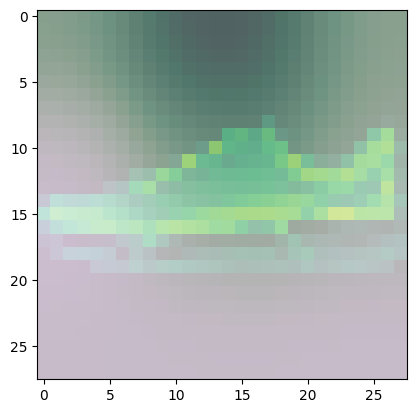

Predicted Class = 7, Probability = 0.99996024


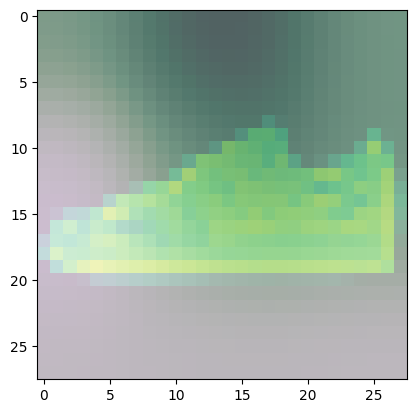

Predicted Class = 7, Probability = 0.9999992


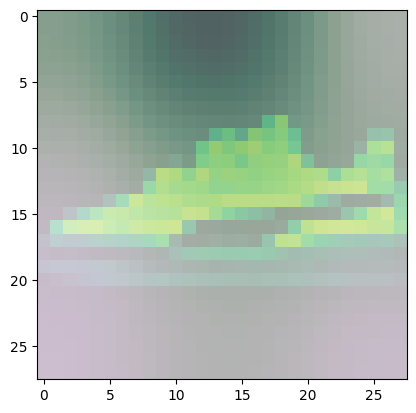

Predicted Class = 7, Probability = 0.99984837


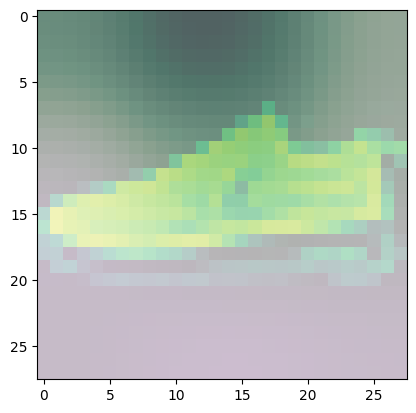

Predicted Class = 7, Probability = 0.91839415


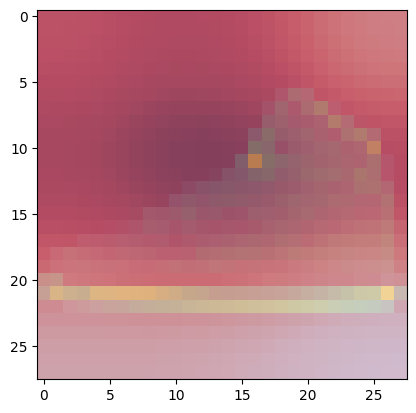

Predicted Class = 7, Probability = 0.99993664


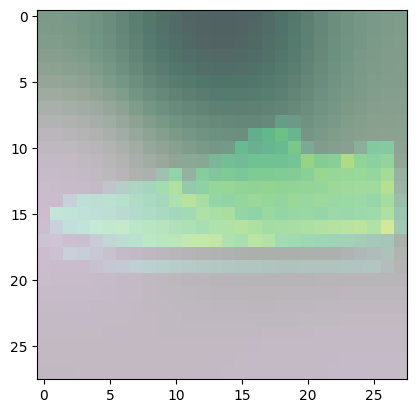

Predicted Class = 7, Probability = 0.99492025


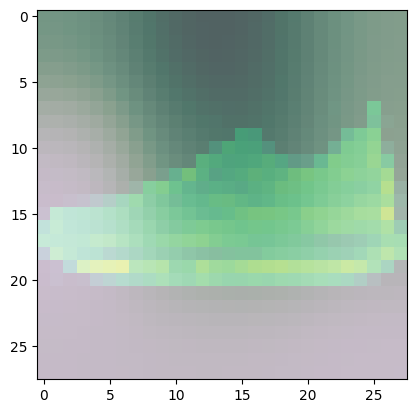

Predicted Class = 7, Probability = 0.95925385


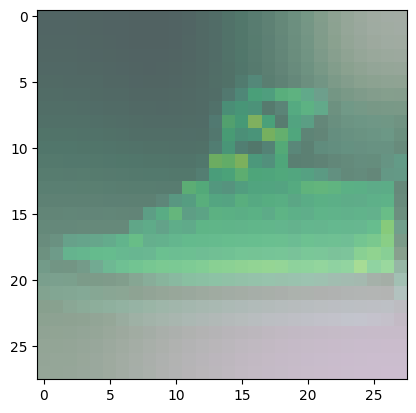

Predicted Class = 7, Probability = 0.99962527


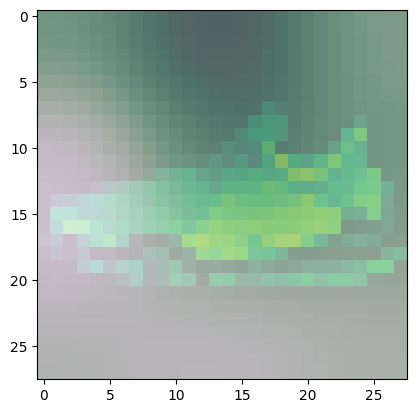

Predicted Class = 7, Probability = 0.9997026


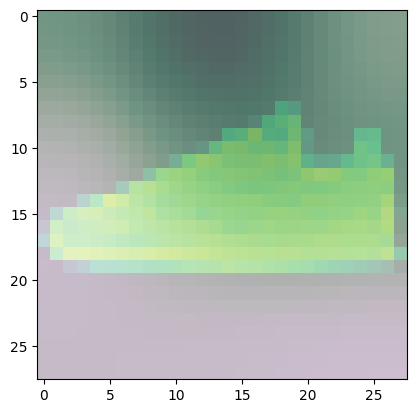

Predicted Class = 7, Probability = 0.99997824


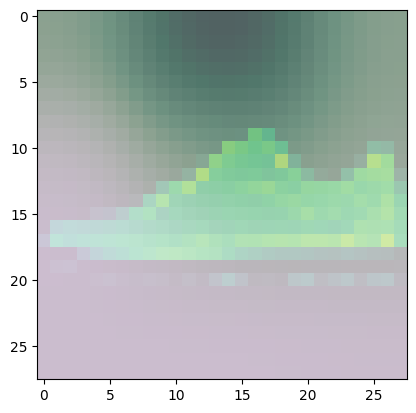

Predicted Class = 7, Probability = 0.99991876


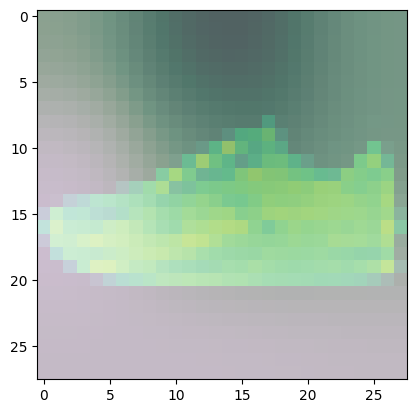

Predicted Class = 7, Probability = 0.78641033


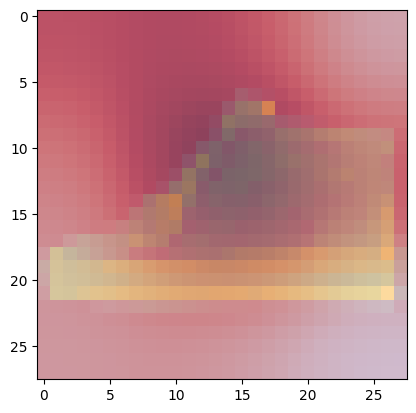

Predicted Class = 7, Probability = 0.9999781


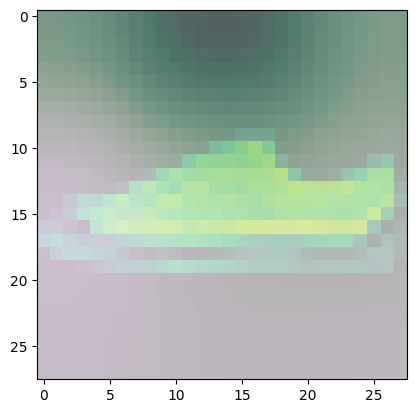

Predicted Class = 7, Probability = 0.99747795


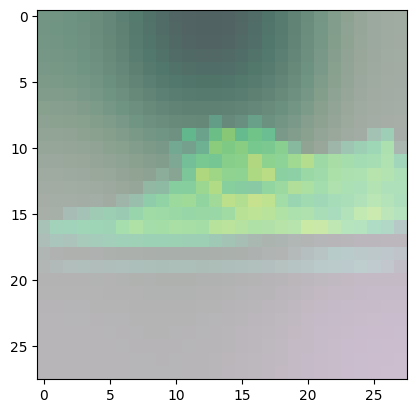

Predicted Class = 7, Probability = 0.99933964


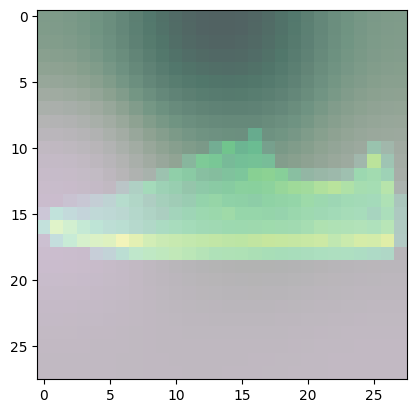

Predicted Class = 7, Probability = 0.99936265


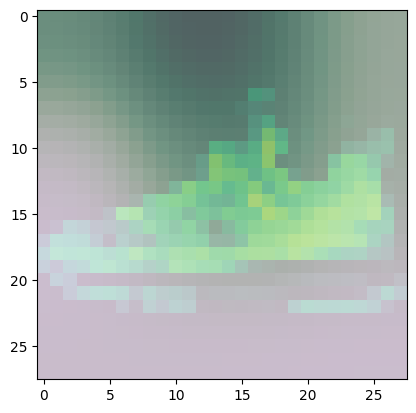

Predicted Class = 7, Probability = 0.97617483


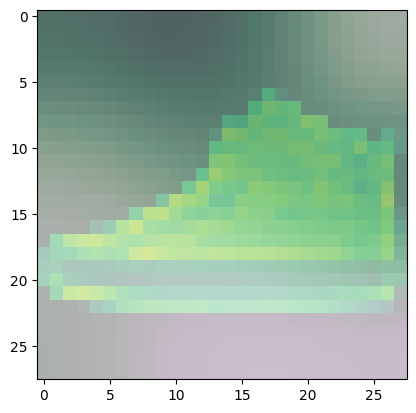

Predicted Class = 7, Probability = 0.9999953


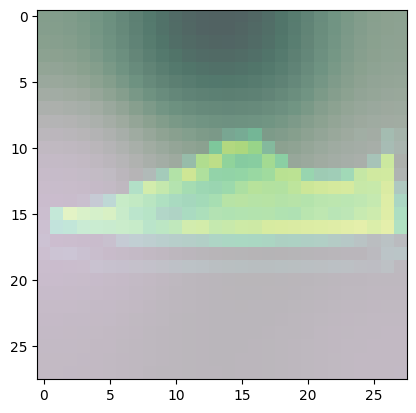

Predicted Class = 7, Probability = 0.9999705


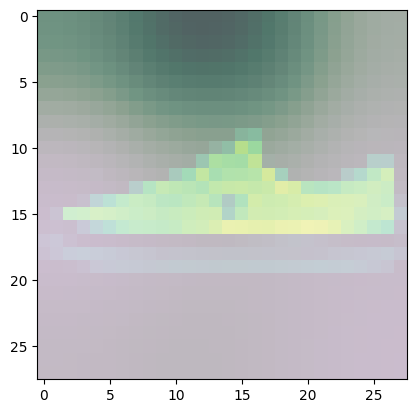

In [29]:
show_maps(desired_class=7, num_maps=20)